# Twitter Scraper using Selenium

Scraper for Twitter Tweets using selenium. It can scrape tweets from:
- Home/New Feeds
- User Profile Tweets
- Query or Search Tweets
- Hashtags Tweets
- Advanced Search Tweets

In [1]:
!pip install selenium

  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.1 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install fake_headers pandas webdriver_manager python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import sys
import pandas as pd

from datetime import datetime
from fake_headers import Headers
from time import sleep
from selenium import webdriver
from selenium.webdriver import Chrome
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import (
    NoSuchElementException,
    StaleElementReferenceException,
    WebDriverException,
)
from selenium.webdriver.common.action_chains import ActionChains

from selenium.webdriver.chrome.webdriver import WebDriver
from selenium.webdriver.chrome.options import Options as ChromeOptions
from selenium.webdriver.chrome.service import Service as ChromeService

from webdriver_manager.chrome import ChromeDriverManager

# Progress Class

Class for the progress of the scraper instance.

In [2]:
class Progress:
    def __init__(self, current, total) -> None:
        self.current = current
        self.total = total
        pass

    def print_progress(self, current) -> None:
        self.current = current
        progress = current / self.total
        bar_length = 40
        progress_bar = (
            "["
            + "=" * int(bar_length * progress)
            + "-" * (bar_length - int(bar_length * progress))
            + "]"
        )
        sys.stdout.write(
            "\rProgress: [{:<40}] {:.2%} {} of {}".format(
                progress_bar, progress, current, self.total
            )
        )
        sys.stdout.flush()


# Scroller Class

Class for the scrollbar of the web page.

In [3]:
class Scroller:
    def __init__(self, driver) -> None:
        self.driver = driver
        self.current_position = 0
        self.last_position = driver.execute_script("return window.pageYOffset;")
        self.scrolling = True
        self.scroll_count = 0
        pass

    def reset(self) -> None:
        self.current_position = 0
        self.last_position = self.driver.execute_script("return window.pageYOffset;")
        self.scroll_count = 0
        pass

    def scroll_to_top(self) -> None:
        self.driver.execute_script("window.scrollTo(0, 0);")
        pass

    def scroll_to_bottom(self) -> None:
        self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        pass

    def update_scroll_position(self) -> None:
        self.current_position = self.driver.execute_script("return window.pageYOffset;")
        pass


# Tweet Class

Object for the tweet. Including its data.

In [4]:
class Tweet:
    def __init__(
        self,
        card: WebDriver,
        driver: WebDriver,
        actions: ActionChains,
        scrape_poster_details=False
    ) -> None:
        self.card = card
        self.error = False
        self.tweet = None

        try:
            self.user = card.find_element(
                "xpath", './/div[@data-testid="User-Name"]//span'
            ).text
        except NoSuchElementException:
            self.error = True
            self.user = "skip"

        try:
            self.handle = card.find_element(
                "xpath", './/span[contains(text(), "@")]'
            ).text
        except NoSuchElementException:
            self.error = True
            self.handle = "skip"

        try:
            self.date_time = card.find_element("xpath", ".//time").get_attribute(
                "datetime"
            )

            if self.date_time is not None:
                self.is_ad = False
        except NoSuchElementException:
            self.is_ad = True
            self.error = True
            self.date_time = "skip"
        
        if self.error:
            return

        try:
            card.find_element(
                "xpath", './/*[local-name()="svg" and @data-testid="icon-verified"]'
            )

            self.verified = True
        except NoSuchElementException:
            self.verified = False

        self.content = ""
        contents = card.find_elements(
            "xpath",
            '(.//div[@data-testid="tweetText"])[1]/span | (.//div[@data-testid="tweetText"])[1]/a',
        )

        for index, content in enumerate(contents):
            self.content += content.text

        try:
            self.reply_cnt = card.find_element(
                "xpath", './/div[@data-testid="reply"]//span'
            ).text
            
            if self.reply_cnt == "":
                self.reply_cnt = "0"
        except NoSuchElementException:
            self.reply_cnt = "0"

        try:
            self.retweet_cnt = card.find_element(
                "xpath", './/div[@data-testid="retweet"]//span'
            ).text
            
            if self.retweet_cnt == "":
                self.retweet_cnt = "0"
        except NoSuchElementException:
            self.retweet_cnt = "0"

        try:
            self.like_cnt = card.find_element(
                "xpath", './/div[@data-testid="like"]//span'
            ).text
            
            if self.like_cnt == "":
                self.like_cnt = "0"
        except NoSuchElementException:
            self.like_cnt = "0"

        try:
            self.analytics_cnt = card.find_element(
                "xpath", './/a[contains(@href, "/analytics")]//span'
            ).text
            
            if self.analytics_cnt == "":
                self.analytics_cnt = "0"
        except NoSuchElementException:
            self.analytics_cnt = "0"

        try:
            self.tags = card.find_elements(
                "xpath",
                './/a[contains(@href, "src=hashtag_click")]',
            )

            self.tags = [tag.text for tag in self.tags]
        except NoSuchElementException:
            self.tags = []
        
        try:
            self.mentions = card.find_elements(
                "xpath",
                '(.//div[@data-testid="tweetText"])[1]//a[contains(text(), "@")]',
            )

            self.mentions = [mention.text for mention in self.mentions]
        except NoSuchElementException:
            self.mentions = []
        
        try:
            raw_emojis = card.find_elements(
                "xpath",
                '(.//div[@data-testid="tweetText"])[1]/img[contains(@src, "emoji")]',
            )
            
            self.emojis = [emoji.get_attribute("alt").encode("unicode-escape").decode("ASCII") for emoji in raw_emojis]
        except NoSuchElementException:
            self.emojis = []
        
        try:
            self.profile_img = card.find_element(
                "xpath", './/div[@data-testid="Tweet-User-Avatar"]//img'
            ).get_attribute("src")
        except NoSuchElementException:
            self.profile_img = ""
            
        try:
            self.tweet_link = self.card.find_element(
                "xpath",
                ".//a[contains(@href, '/status/')]",
            ).get_attribute("href")
            self.tweet_id = str(self.tweet_link.split("/")[-1])
        except NoSuchElementException:
            self.tweet_link = ""
            self.tweet_id = ""
        
        self.following_cnt = "0"
        self.followers_cnt = "0"
        self.user_id = None
        
        if scrape_poster_details:
            el_name = card.find_element(
                "xpath", './/div[@data-testid="User-Name"]//span'
            )
            
            ext_hover_card = False
            ext_user_id = False
            ext_following = False
            ext_followers = False
            hover_attempt = 0
            
            while not ext_hover_card or not ext_user_id or not ext_following or not ext_followers:
                try:
                    actions.move_to_element(el_name).perform()
                    
                    hover_card = driver.find_element(
                        "xpath",
                        '//div[@data-testid="hoverCardParent"]'
                    )
                    
                    ext_hover_card = True
                    
                    while not ext_user_id:
                        try:
                            raw_user_id = hover_card.find_element(
                                "xpath",
                                '(.//div[contains(@data-testid, "-follow")]) | (.//div[contains(@data-testid, "-unfollow")])'
                            ).get_attribute("data-testid")
                            
                            if raw_user_id == "":
                                self.user_id = None
                            else:
                                self.user_id = str(raw_user_id.split("-")[0])
                            
                            ext_user_id = True
                        except NoSuchElementException:
                            continue
                        except StaleElementReferenceException:
                            self.error = True
                            return
                    
                    while not ext_following:
                        try:
                            self.following_cnt = hover_card.find_element(
                                "xpath",
                                './/a[contains(@href, "/following")]//span'
                            ).text
                            
                            if self.following_cnt == "":
                                self.following_cnt = "0"
                                
                            ext_following = True
                        except NoSuchElementException:
                            continue
                        except StaleElementReferenceException:
                            self.error = True
                            return
                    
                    while not ext_followers:
                        try:
                            self.followers_cnt = hover_card.find_element(
                                "xpath",
                                './/a[contains(@href, "/verified_followers")]//span'
                            ).text
                            
                            if self.followers_cnt == "":
                                self.followers_cnt = "0"
                            
                            ext_followers = True
                        except NoSuchElementException:
                            continue
                        except StaleElementReferenceException:
                            self.error = True
                            return
                except NoSuchElementException:
                    if hover_attempt==3:
                        self.error
                        return
                    hover_attempt+=1
                    sleep(0.5)
                    continue
                except StaleElementReferenceException:
                    self.error = True
                    return
            
            if ext_hover_card and ext_following and ext_followers:
                actions.reset_actions()
        
        self.tweet = (
            self.user,
            self.handle,
            self.date_time,
            self.verified,
            self.content,
            self.reply_cnt,
            self.retweet_cnt,
            self.like_cnt,
            self.analytics_cnt,
            self.tags,
            self.mentions,
            self.emojis,
            self.profile_img,
            self.tweet_link,
            self.tweet_id,
            self.user_id,
            self.following_cnt,
            self.followers_cnt,
        )

        pass


# Twitter Scraper Class

Class for the Twitter Scraper.

In [5]:
TWITTER_LOGIN_URL = "https://twitter.com/i/flow/login"

class Twitter_Scraper:
    def __init__(
        self,
        username,
        password,
        max_tweets=50,
        scrape_username=None,
        scrape_hashtag=None,
        scrape_query=None,
        scrape_poster_details=False,
        scrape_latest=False,
        scrape_top=True,
    ):
        print("Initializing Twitter Scraper...")
        self.username = username
        self.password = password
        self.interrupted = False
        self.tweet_ids = set()
        self.data = []
        self.tweet_cards = []
        self.scraper_details = {
            "type": None,
            "username": None,
            "hashtag": None,
            "query": None,
            "tab": None,
            "poster_details": False,
        }
        self.max_tweets = max_tweets
        self.progress = Progress(0, max_tweets)
        self.router = self.go_to_home
        self.driver = self._get_driver()
        self.actions = ActionChains(self.driver)
        self.scroller = Scroller(self.driver)
        self._config_scraper(
            max_tweets,
            scrape_username,
            scrape_hashtag,
            scrape_query,
            scrape_latest,
            scrape_top,
            scrape_poster_details,
        )

    def _config_scraper(
        self,
        max_tweets=50,
        scrape_username=None,
        scrape_hashtag=None,
        scrape_query=None,
        scrape_latest=True,
        scrape_top=False,
        scrape_poster_details=False,
    ):
        self.tweet_ids = set()
        self.data = []
        self.tweet_cards = []
        self.max_tweets = max_tweets
        self.progress = Progress(0, max_tweets)
        self.scraper_details = {
            "type": None,
            "username": scrape_username,
            "hashtag": str(scrape_hashtag).replace("#", "")
            if scrape_hashtag is not None
            else None,
            "query": scrape_query,
            "tab": "Latest" if scrape_latest else "Top" if scrape_top else "Latest",
            "poster_details": scrape_poster_details,
        }
        self.router = self.go_to_home
        self.scroller = Scroller(self.driver)

        if scrape_username is not None:
            self.scraper_details["type"] = "Username"
            self.router = self.go_to_profile
        elif scrape_hashtag is not None:
            self.scraper_details["type"] = "Hashtag"
            self.router = self.go_to_hashtag
        elif scrape_query is not None:
            self.scraper_details["type"] = "Query"
            self.router = self.go_to_search
        else:
            self.scraper_details["type"] = "Home"
            self.router = self.go_to_home
        pass

    def _get_driver(self):
        print("Setup WebDriver...")
        header = Headers().generate()["User-Agent"]

        browser_option = ChromeOptions()
        browser_option.add_argument("--no-sandbox")
        browser_option.add_argument("--disable-dev-shm-usage")
        browser_option.add_argument("--ignore-certificate-errors")
        browser_option.add_argument("--disable-gpu")
        browser_option.add_argument("--log-level=3")
        browser_option.add_argument("--disable-notifications")
        browser_option.add_argument("--disable-popup-blocking")
        browser_option.add_argument("--user-agent={}".format(header))

        # For Hiding Browser
        browser_option.add_argument("--headless")

        try:
            print("Initializing ChromeDriver...")
            driver = webdriver.Chrome(
                options=browser_option,
            )

            print("WebDriver Setup Complete")
            return driver
        except WebDriverException:
            try:
                print("Downloading ChromeDriver...")
                chromedriver_path = ChromeDriverManager().install()
                chrome_service = ChromeService(executable_path=chromedriver_path)

                print("Initializing ChromeDriver...")
                driver = webdriver.Chrome(
                    service=chrome_service,
                    options=browser_option,
                )

                print("WebDriver Setup Complete")
                return driver
            except Exception as e:
                print(f"Error setting up WebDriver: {e}")
                sys.exit(1)
        pass

    def login(self):
        print()
        print("Logging in to Twitter...")

        try:
            self.driver.maximize_window()
            self.driver.get(TWITTER_LOGIN_URL)
            sleep(3)

            self._input_username()
            self._input_unusual_activity()
            self._input_password()

            cookies = self.driver.get_cookies()

            auth_token = None

            for cookie in cookies:
                if cookie["name"] == "auth_token":
                    auth_token = cookie["value"]
                    break

            if auth_token is None:
                raise ValueError(
                    """This may be due to the following:

- Internet connection is unstable
- Username is incorrect
- Password is incorrect
"""
                )

            print()
            print("Login Successful")
            print()
        except Exception as e:
            print()
            print(f"Login Failed: {e}")
            sys.exit(1)

        pass

    def _input_username(self):
        input_attempt = 0

        while True:
            try:
                username = self.driver.find_element(
                    "xpath", "//input[@autocomplete='username']"
                )

                username.send_keys(self.username)
                username.send_keys(Keys.RETURN)
                sleep(3)
                break
            except NoSuchElementException:
                input_attempt += 1
                if input_attempt >= 3:
                    print()
                    print(
                        """There was an error inputting the username.

It may be due to the following:
- Internet connection is unstable
- Username is incorrect
- Twitter is experiencing unusual activity"""
                    )
                    self.driver.quit()
                    sys.exit(1)
                else:
                    print("Re-attempting to input username...")
                    sleep(2)

    def _input_unusual_activity(self):
        input_attempt = 0

        while True:
            try:
                unusual_activity = self.driver.find_element(
                    "xpath", "//input[@data-testid='ocfEnterTextTextInput']"
                )
                unusual_activity.send_keys(self.username)
                unusual_activity.send_keys(Keys.RETURN)
                sleep(3)
                break
            except NoSuchElementException:
                input_attempt += 1
                if input_attempt >= 3:
                    break

    def _input_password(self):
        input_attempt = 0

        while True:
            try:
                password = self.driver.find_element(
                    "xpath", "//input[@autocomplete='current-password']"
                )

                password.send_keys(self.password)
                password.send_keys(Keys.RETURN)
                sleep(3)
                break
            except NoSuchElementException:
                input_attempt += 1
                if input_attempt >= 3:
                    print()
                    print(
                        """There was an error inputting the password.

It may be due to the following:
- Internet connection is unstable
- Password is incorrect
- Twitter is experiencing unusual activity"""
                    )
                    self.driver.quit()
                    sys.exit(1)
                else:
                    print("Re-attempting to input password...")
                    sleep(2)

    def go_to_home(self):
        self.driver.get("https://twitter.com/home")
        sleep(3)
        pass

    def go_to_profile(self):
        if (
            self.scraper_details["username"] is None
            or self.scraper_details["username"] == ""
        ):
            print("Username is not set.")
            sys.exit(1)
        else:
            self.driver.get(f"https://twitter.com/{self.scraper_details['username']}")
            sleep(3)
        pass

    def go_to_hashtag(self):
        if (
            self.scraper_details["hashtag"] is None
            or self.scraper_details["hashtag"] == ""
        ):
            print("Hashtag is not set.")
            sys.exit(1)
        else:
            url = f"https://twitter.com/hashtag/{self.scraper_details['hashtag']}?src=hashtag_click"
            if self.scraper_details["tab"] == "Latest":
                url += "&f=live"

            self.driver.get(url)
            sleep(3)
        pass

    def go_to_search(self):
        if self.scraper_details["query"] is None or self.scraper_details["query"] == "":
            print("Query is not set.")
            sys.exit(1)
        else:
            url = f"https://twitter.com/search?q={self.scraper_details['query']}&src=typed_query"
            if self.scraper_details["tab"] == "Latest":
                url += "&f=live"

            self.driver.get(url)
            sleep(1)
        pass

    def get_tweet_cards(self):
        self.tweet_cards = self.driver.find_elements(
            "xpath", '//article[@data-testid="tweet" and not(@disabled)]'
        )
        pass

    def remove_hidden_cards(self):
        try:
            hidden_cards = self.driver.find_elements(
                "xpath", '//article[@data-testid="tweet" and @disabled]'
            )

            for card in hidden_cards[1:-2]:
                self.driver.execute_script(
                    "arguments[0].parentNode.parentNode.parentNode.remove();", card
                )
        except Exception as e:
            return
        pass

    def scrape_tweets(
        self,
        max_tweets=50,
        scrape_username=None,
        scrape_hashtag=None,
        scrape_query=None,
        scrape_latest=True,
        scrape_top=False,
        scrape_poster_details=False,
        router=None,
    ):
        self._config_scraper(
            max_tweets,
            scrape_username,
            scrape_hashtag,
            scrape_query,
            scrape_latest,
            scrape_top,
            scrape_poster_details,
        )

        if router is None:
            router = self.router

        router()

        if self.scraper_details["type"] == "Username":
            print(
                "Scraping Tweets from @{}...".format(self.scraper_details["username"])
            )
        elif self.scraper_details["type"] == "Hashtag":
            print(
                "Scraping {} Tweets from #{}...".format(
                    self.scraper_details["tab"], self.scraper_details["hashtag"]
                )
            )
        elif self.scraper_details["type"] == "Query":
            print(
                "Scraping {} Tweets from {} search...".format(
                    self.scraper_details["tab"], self.scraper_details["query"]
                )
            )
        elif self.scraper_details["type"] == "Home":
            print("Scraping Tweets from Home...")

        self.progress.print_progress(0)

        refresh_count = 0
        added_tweets = 0
        empty_count = 0

        while self.scroller.scrolling:
            try:
                self.get_tweet_cards()
                added_tweets = 0

                for card in self.tweet_cards[-15:]:
                    try:
                        tweet_id = str(card)

                        if tweet_id not in self.tweet_ids:
                            self.tweet_ids.add(tweet_id)

                            if not self.scraper_details["poster_details"]:
                                self.driver.execute_script(
                                    "arguments[0].scrollIntoView();", card
                                )

                            tweet = Tweet(
                                card=card,
                                driver=self.driver,
                                actions=self.actions,
                                scrape_poster_details=self.scraper_details[
                                    "poster_details"
                                ],
                            )

                            if tweet:
                                if not tweet.error and tweet.tweet is not None:
                                    if not tweet.is_ad:
                                        self.data.append(tweet.tweet)
                                        added_tweets += 1
                                        self.progress.print_progress(len(self.data))
                                        sleep(1)
                                        if len(self.data) >= self.max_tweets:
                                            self.scroller.scrolling = False
                                            break
                                    else:
                                        continue
                                else:
                                    continue
                            else:
                                continue
                        else:
                            continue
                    except NoSuchElementException:
                        continue

                if len(self.data) >= self.max_tweets:
                    break

                if added_tweets == 0:
                    if empty_count >= 5:
                        if refresh_count >= 3:
                            print()
                            print("No more tweets to scrape")
                            break
                        refresh_count += 1
                    empty_count += 1
                    sleep(5)
                else:
                    empty_count = 0
                    refresh_count = 0
            except StaleElementReferenceException:
                sleep(10)
                continue
            except KeyboardInterrupt:
                print("\n")
                print("Keyboard Interrupt")
                self.interrupted = True
                break
            except Exception as e:
                print("\n")
                print(f"Error scraping tweets: {e}")
                break

        print("")

        if len(self.data) >= self.max_tweets:
            print("Scraping Complete")
        else:
            print("Scraping Incomplete")

        print("Tweets: {} out of {}\n".format(len(self.data), self.max_tweets))

        pass

    def save_to_csv(self,name):
        print("Saving Tweets to CSV...")
        now = datetime.now()
        folder_path = "./tweets/"

        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            print("Created Folder: {}".format(folder_path))

        data = {
            "Name": [tweet[0] for tweet in self.data],
            "Handle": [tweet[1] for tweet in self.data],
            "Timestamp": [tweet[2] for tweet in self.data],
            "Verified": [tweet[3] for tweet in self.data],
            "Content": [tweet[4] for tweet in self.data],
            "Comments": [tweet[5] for tweet in self.data],
            "Retweets": [tweet[6] for tweet in self.data],
            "Likes": [tweet[7] for tweet in self.data],
            "Analytics": [tweet[8] for tweet in self.data],
            "Tags": [tweet[9] for tweet in self.data],
            "Mentions": [tweet[10] for tweet in self.data],
            "Emojis": [tweet[11] for tweet in self.data],
            "Profile Image": [tweet[12] for tweet in self.data],
            "Tweet Link": [tweet[13] for tweet in self.data],
            "Tweet ID": [f'tweet_id:{tweet[14]}' for tweet in self.data],
        }

        if self.scraper_details["poster_details"]:
            data["Tweeter ID"] = [f'user_id:{tweet[15]}' for tweet in self.data]
            data["Following"] = [tweet[16] for tweet in self.data]
            data["Followers"] = [tweet[17] for tweet in self.data]

        df = pd.DataFrame(data)

        current_time = now.strftime("%Y-%m-%d_%H-%M-%S")
        file_path = f"{folder_path}{name}_1-{len(self.data)}.csv"
        pd.set_option("display.max_colwidth", None)
        df.to_csv(file_path, index=False, encoding="utf-8")

        print("CSV Saved: {}".format(file_path))

        pass

    def get_tweets(self):
        return self.data

# Create a new instance of the Twitter Scraper class

In [8]:
pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [6]:
from dotenv import load_dotenv, dotenv_values 
load_dotenv()
USER_UNAME = "ItoutTry71369"
USER_PASSWORD = "ABCDEFGHIJ"
print(USER_UNAME)
scraper = Twitter_Scraper(
    username=USER_UNAME,
    password=USER_PASSWORD,
    # max_tweets=10,
    # scrape_username="something",
    # scrape_hashtag="something",
    # scrape_query="something",
    # scrape_latest=False,
    # scrape_top=True,
    # scrape_poster_details=True
)

ItoutTry71369
Initializing Twitter Scraper...
Setup WebDriver...
Initializing ChromeDriver...
WebDriver Setup Complete


In [7]:
scraper.login()


Logging in to Twitter...

Login Successful



# Run Twitter Scraper

In [8]:
scraper.scrape_tweets(
    max_tweets=1000,
    # scrape_username="something",
    # scrape_hashtag="something",
    scrape_query="Farmers' Protest lang:en ",
    # scrape_latest=True,
    scrape_top=False,
    # scrape_poster_details=True,
)

Scraping Latest Tweets from Farmers' Protest lang:en  search...
Progress: [[===============-------------------------]] 38.80% 388 of 1000
No more tweets to scrape

Scraping Incomplete
Tweets: 388 out of 1000



# Save Scraped Tweets in a CSV

In [9]:
scraper.save_to_csv("Farmers' Protest")

Saving Tweets to CSV...
CSV Saved: ./tweets/Farmers' Protest_1-388.csv


In [16]:
scraper.driver.close()

 # Summarisation code:

In [20]:
# Import necessary libraries from Hugging Face's transformers library
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

# Function for BART summarization
def summarize_with_bart(text, max_length=150, min_length=50):
    model_name = 'facebook/bart-large-cnn'
    tokenizer = BartTokenizer.from_pretrained(model_name)
    model = BartForConditionalGeneration.from_pretrained(model_name)

    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function for T5 summarization
def summarize_with_t5(text, max_length=150, min_length=50):
    model_name = 't5-base'
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)

    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function for Pegasus summarization
def summarize_with_pegasus(text, max_length=150, min_length=50):
    model_name = 'google/pegasus-cnn_dailymail'
    tokenizer = PegasusTokenizer.from_pretrained(model_name)
    model = PegasusForConditionalGeneration.from_pretrained(model_name)

    inputs = tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Example usage of all three models

    text="""The Beauty of Life: A Reflection on Joy, Struggle, and Growth
    Life, in all its complexity, is a profound and beautiful journey. Each person experiences it uniquely, shaped by the intersection of circumstances, decisions, emotions, and interactions. Beauty in life isn't found solely in moments of happiness and success; it's in the ebb and flow of joys, struggles, challenges, and growth. Understanding the beauty of life requires a perspective that sees beyond the surface, recognizing that every experience, whether positive or negative, contributes to the intricate mosaic that is existence.

    The Beauty of Simplicity
    One of the most profound aspects of life is its inherent simplicity. We often become consumed by the chaos and noise of everyday demands, but in moments of stillness, we find beauty in simplicity. The warmth of the sun on your skin, the sound of a bird chirping at dawn, the fragrance of flowers in bloom, or the comforting silence of a peaceful evening—these are the small, simple pleasures that remind us of the world’s beauty.

    Nature, in particular, is a powerful symbol of life’s beauty. The changing seasons, each with its own character, mirror the phases of our lives. Spring’s rebirth and renewal reflect new beginnings, while autumn’s fading leaves signify the passage of time. The vastness of the ocean and the endless horizon offer a humbling reminder of the world’s grandeur, which extends beyond human comprehension. Life’s beauty lies in its diversity, from the grandeur of natural landscapes to the minutiae of everyday moments.
"""
    # Summarize using BART
    bart_summary = summarize_with_bart(text)
    print("BART Summary:", bart_summary)

    print("done")
    # Summarize using T5
    t5_summary = summarize_with_t5(text)
    print("\nT5 Summary:", t5_summary)

    # Summarize using Pegasus
    pegasus_summary = summarize_with_pegasus(text)
    print("\nPegasus Summary:", pegasus_summary)


In [3]:
pip install ipywidgets

   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.3 MB 2.4 MB/s eta 0:00:01
   ------------- -------------------------- 0.8/2.3 MB 1.6 MB/s eta 0:00:01
   ----------------- ---------------------- 1.0/2.3 MB 1.7 MB/s eta 0:00:01
   -------------------------- ------------- 1.6/2.3 MB 1.8 MB/s eta 0:00:01
   ------------------------------- -------- 1.8/2.3 MB 1.7 MB/s eta 0:00:01
   ------------------------------- -------- 1.8/2.3 MB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install nltk

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 4.2 MB/s eta 0:00:01
   ---------------------------------- ----- 1.3/1.5 MB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Download required NLTK resources
nltk.download('popular')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the Excel file
file_path = 'trumptweets.csv'
sheet_name = 'Sheet1'  # Adjust as necessary
tweets_df = pd.read_csv(file_path)

# Assuming tweets are in a column named 'content'
tweets = tweets_df['Content'].tolist()

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    
    # Remove mentions and hashtags
    tweet = re.sub(r'@\w+|#\w+', '', tweet)
    
    # Remove special characters, numbers, and punctuation
    tweet = re.sub(r'\d+', '', tweet)  # Remove numbers
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Tokenize the tweet
    tokens = word_tokenize(tweet)
    
    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Remove non-ASCII characters
    tokens = [word for word in tokens if word.isascii()]
    
    # Rejoin tokens into a clean string
    clean_text = ' '.join(tokens)
    
    # Remove extra whitespace
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    
    return clean_text

# Apply cleaning function to each tweet
cleaned_tweets = [clean_tweet(tweet) for tweet in tweets]

# Add cleaned tweets back to the DataFrame
tweets_df['cleaned_content'] = cleaned_tweets

# Save cleaned tweets to a new Excel file
tweets_df.to_excel('cleaned_tweets.xlsx', index=False)

print("Cleaning completed and saved to 'cleaned_tweets.xlsx'.")


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\ranah\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\cmudict.zip.
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\ranah\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\gazetteers.zip.
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\ranah\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\genesis.zip.
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\ranah\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\gutenberg.zip.
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\ranah\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     C:\Users\ranah\AppData\Roaming\nl

Cleaning completed and saved to 'cleaned_tweets.xlsx'.


In [10]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu124



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\ranah\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\ranah\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

C:\Users\ranah\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


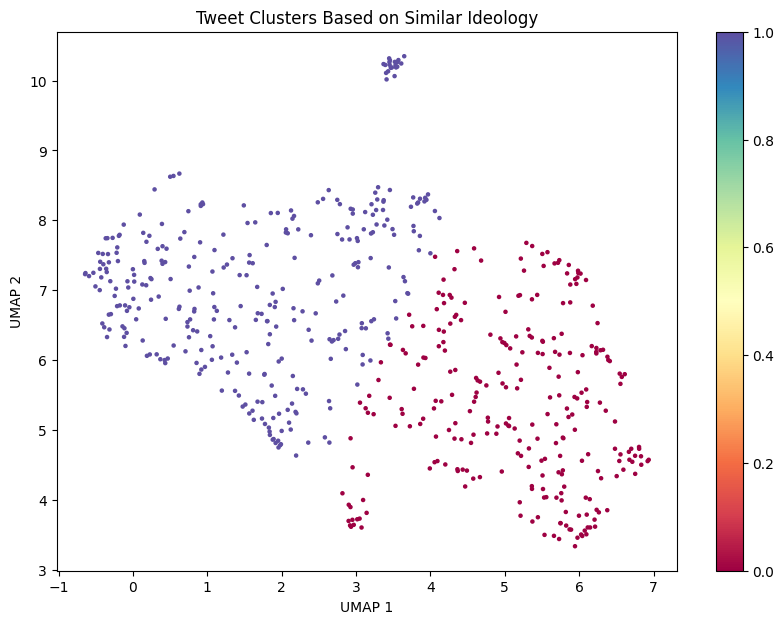

Clustering completed and saved to 'clustered_tweets.xlsx'.


In [17]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt

# Load the cleaned tweets
file_path = 'cleaned_tweets.xlsx'
tweets_df = pd.read_excel(file_path)
tweets = tweets_df['Content'].tolist()

# Step 1: Use Sentence Transformers (BERT-based) to encode tweets
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(tweets, show_progress_bar=True)

# Step 2: Dimensionality Reduction with UMAP
umap_reducer = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
reduced_embeddings = umap_reducer.fit_transform(embeddings)

# Step 3: Clustering using K-Means
num_clusters = 2  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(reduced_embeddings)
cluster_labels = kmeans.labels_

# Add cluster labels to the DataFrame
tweets_df['cluster'] = cluster_labels

# Step 4: Visualize the Clusters
plt.figure(figsize=(10, 7))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='Spectral', s=5)
plt.title('Tweet Clusters Based on Similar Ideology')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.show()

# Save the clustered data
tweets_df.to_excel('clustered_tweets.xlsx', index=False)
print("Clustering completed and saved to 'clustered_tweets.xlsx'.")


In [1]:
import pandas as pd
from transformers import pipeline

# Step 1: Load Tweets from Excel File
# Replace 'tweets.xlsx' with the path to your Excel file and specify the correct sheet name
file_path = 'C:\Learn\IPD\\backend\processed_predictions2.csv'

tweets_df = pd.read_csv(file_path)

# Assuming the tweets are in a column named 'content'
clustered_tweets = tweets_df.groupby('Prominent_Label')['Content'].apply(list).to_dict()
# Step 2: Load Pre-trained BART Model for Summarization
summarizer = pipeline("summarization", model="facebook/bart-large-cnn",device='cuda')

# Step 3: Define a Function to Batch Summarize Tweets
def summarize_tweets(tweets, max_batch_size=10):
    summaries = tweets
    batch = []

    while len(summaries)!=1:
        tweets=summaries
        summaries=[]
        for tweet in tweets:
            batch.append(tweet)
                
            # Summarize when reaching batch size or at the end of the list
            if len(batch) == max_batch_size or tweet == tweets[-1]:
                # Join tweets in a batch into one text with separators (adjust if needed)
                batch_text = " ".join(batch)
                    
                    # Summarize the batch
                try:
                    summary = summarizer(batch_text, max_length=250, min_length=20, do_sample=False)[0]['summary_text']
                    summaries.append(summary)
                except Exception as e:
                    print(f"Error summarizing batch: {e}")
                    summaries.append("Error in summarization.")
                    
                # Reset the batch
                batch = []
        
    return summaries

# # Step 4: Summarize the Tweets
# summaries = summarize_tweets(tweets)

# # Step 5: Save the Summaries to a New Excel File
# summary_df = pd.DataFrame({'summary': summaries})
# summary_df.to_excel('summarized_tweets_whole.xlsx', index=False)

# print("Summarization completed and saved to 'summarized_tweets.xlsx'.")

cluster_summaries = {}
for cluster, tweets in clustered_tweets.items():
    print(f"Summarizing cluster {cluster} with {len(tweets)} tweets...")
    cluster_summaries[cluster] = summarize_tweets(tweets)

# Convert summaries to a DataFrame for saving
summary_df = pd.DataFrame(list(cluster_summaries.items()), columns=['Cluster', 'Summary'])

# Save the summaries to an Excel file
summary_df.to_csv('cluster_summaries.xlsx', index=False)

print("Summarization completed and saved to 'cluster_summaries.xlsx'.")


c:\Users\ranah\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Summarizing cluster Center with 237 tweets...


c:\Users\ranah\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\bart\modeling_bart.py:496: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Your max_length is set to 250, but your input_length is only 232. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=116)
Your max_length is set to 250, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8

Summarizing cluster Left with 19 tweets...


Your max_length is set to 250, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Summarizing cluster Right with 732 tweets...


Your max_length is set to 250, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 250, but your input_length is only 235. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=117)


Summarization completed and saved to 'cluster_summaries.xlsx'.


True